In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import os
from os import environ
from pathlib import Path
from typing import List

import torch
import pandas as pd
import numpy as np

from hydra import initialize, compose
from hydra.utils import instantiate
from omegaconf import DictConfig, OmegaConf

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from bliss.surveys.des import DarkEnergySurvey, DESDownloader

from pathlib import Path
from hydra import initialize, compose
from bliss.main import predict
import case_studies.galaxy_clustering.utils.diagnostics as diagnostics

In [3]:
environ["CUDA_VISIBLE_DEVICES"] = "6"

In [4]:
with initialize(config_path="../", version_base=None):
    cfg = compose("config", {
        "encoder.tiles_to_crop=0",
        })

In [5]:
cfg.predict

{'dataset': '${surveys.des}', 'trainer': {'_target_': 'pytorch_lightning.Trainer', 'accelerator': 'gpu', 'precision': '${train.trainer.precision}'}, 'encoder': '${encoder}', 'weight_save_path': '${paths.output}/version_23/checkpoints/best_encoder.ckpt', 'device': 'cuda:0'}

In [6]:
encoder = instantiate(cfg.predict.encoder)
enc_state_dict = torch.load(cfg.predict.weight_save_path)
enc_state_dict = enc_state_dict["state_dict"]
encoder.load_state_dict(enc_state_dict)
dataset = instantiate(cfg.cached_simulator)
trainer = instantiate(cfg.predict.trainer)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [7]:
cfg.predict.encoder

{'_target_': 'case_studies.galaxy_clustering.encoder.encoder.GalaxyClusterEncoder', 'survey_bands': ['g', 'r', 'i', 'z'], 'tile_slen': '${simulator.prior.tile_slen}', 'tiles_to_crop': 0, 'min_flux_for_loss': 0, 'min_flux_for_metrics': 0, 'optimizer_params': {'lr': 0.001}, 'scheduler_params': {'milestones': [32], 'gamma': 0.1}, 'image_normalizer': {'_target_': 'bliss.encoder.image_normalizer.ImageNormalizer', 'bands': [0, 1, 2, 3], 'include_original': True, 'include_background': False, 'concat_psf_params': False, 'num_psf_params': 6, 'log_transform_stdevs': None, 'use_clahe': False, 'clahe_min_stdev': None, 'asinh_cutoffs': None}, 'var_dist': {'_target_': 'case_studies.galaxy_clustering.encoder.variational_dist.GalaxyClusterVariationalDist', 'tile_slen': '${encoder.tile_slen}', 'factors': '${variational_factors}'}, 'matcher': {'_target_': 'bliss.encoder.metrics.CatalogMatcher', 'dist_slack': 1.0, 'mag_slack': None, 'mag_band': 2}, 'metrics': {'_target_': 'torchmetrics.MetricCollection',

In [8]:
enc_output = trainer.predict(encoder, datamodule=dataset)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [6]


Predicting: 0it [00:00, ?it/s]

In [9]:
dataloader_iter = iter(dataset.predict_dataloader())

In [10]:
enc_output[0]["mode_cat"]["membership"].shape

torch.Size([2, 10, 10, 1, 1])

In [11]:
truth = next(dataloader_iter)
outputs = enc_output[0]
accuracy = (outputs["mode_cat"]["membership"].to(torch.bool) == truth["tile_catalog"]["membership"].to(torch.bool)).sum()
print(accuracy/(2*10**2))

tensor(0.9650)


In [12]:
(outputs["mode_cat"]["membership"] == truth["tile_catalog"]["membership"]).sum()

tensor(193)

In [13]:
truth["tile_catalog"]["membership"].shape

torch.Size([2, 10, 10, 1, 1])

In [19]:
batch_id = 1
dataloader_iter = iter(dataset.predict_dataloader())
for i in range(batch_id):
    truth = next(dataloader_iter)
    outputs = enc_output[i]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image statistics:
 Accuracy:1.0, 
 Precision: 0.0,
 Recall: 0.0, 
 F1: 0.0


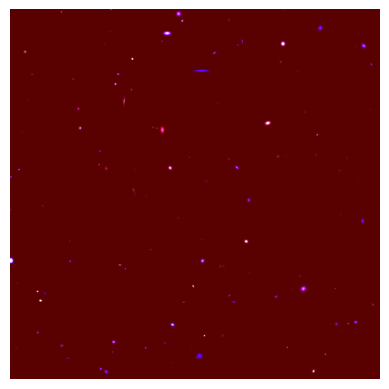

In [22]:

# img_id selects for an image within the batch, i.e., from 0 to batch_size - 1
img_id = 0
crop = 0
n_tiles = 20
tile_size = 128
img_size = 1280

band_idx = {
    "g": 0,
    "r": 1,
    "i": 2,
    "z": 3
}


est_cat = outputs["mode_cat"]["membership"][img_id, crop: n_tiles - crop + 1, crop: n_tiles - crop + 1].to(torch.bool)
true_cat = truth["tile_catalog"]["membership"][img_id, crop: n_tiles - crop + 1, crop: n_tiles - crop + 1].to(torch.bool)

img_acc, img_prec, img_rec, img_f1 =  diagnostics.compute_metrics(est_cat, true_cat)

test_img = truth["images"][img_id][[band_idx["g"], band_idx["r"], band_idx["z"]]]
test_out = outputs["mode_cat"]["membership"][img_id].squeeze()
overlay = diagnostics.create_overlay(test_out, tile_size=tile_size)
blended_image = diagnostics.blend_images(test_img.permute(1,2,0), overlay, alpha=0.35, img_crop=crop*tile_size)

print(f"Image statistics:\n Accuracy:{img_acc}, \n Precision: {img_prec},\n Recall: {img_rec}, \n F1: {img_f1}")
plt.imshow(blended_image)
plt.axis('off')
plt.show()

#est_cat = est_cat.squeeze()
#true_cat = true_cat.squeeze()
#pred_heatmap = 2*est_cat + true_cat

#cmap = ListedColormap(['green', 'yellow', 'orange', 'lime'])

#plt.imshow(pred_heatmap, cmap=cmap)
#cbar = plt.colorbar()

#yticks = np.linspace(*cbar.ax.get_ylim(), cmap.N+1)[:-1]
#yticks += (yticks[1] - yticks[0]) / 2

# add tick labels to colorbar
#cbar.set_ticks(yticks, labels=['true negative','false negative','false positive','true positive'])
#cbar.ax.tick_params(length=0)
#plt.show()

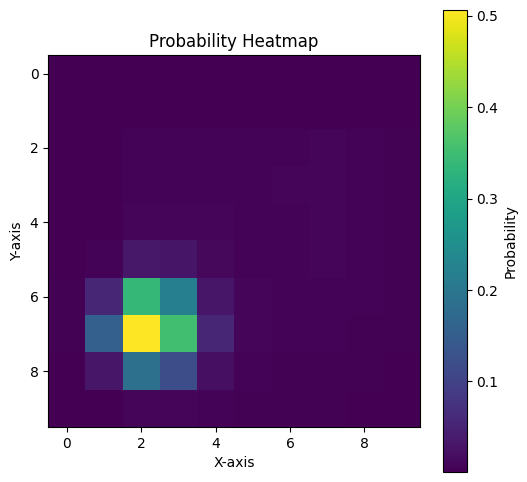

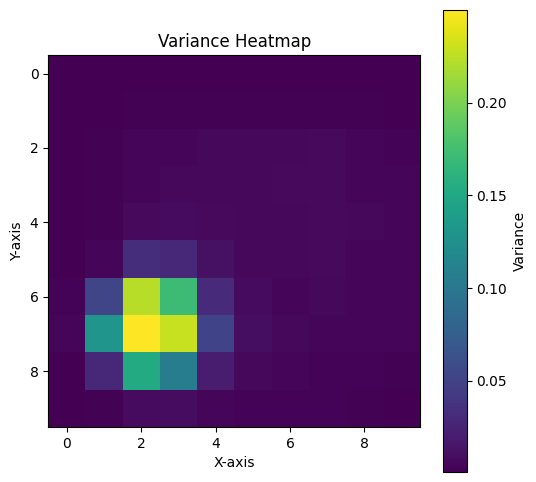

<Figure size 640x480 with 0 Axes>

In [23]:
prob_array = enc_output[1]["parameters"].sigmoid().clamp(1e-4, 1 - 1e-4)[0].squeeze().numpy()
variance = prob_array * (1 - prob_array)

plt.figure(figsize=(6,6))
plt.imshow(prob_array, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Probability')
plt.title('Probability Heatmap')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

plt.figure(figsize=(6,6))
plt.imshow(variance, cmap='viridis', interpolation='nearest')
plt.colorbar(label='Variance')
plt.title('Variance Heatmap')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

plt.tight_layout()